In [ ]:
from depth_pro.utils import load_rgb
from depth_pro import depth_pro
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import numpy as np
import torch

/Users/ewojcik/Code/ai/Depth/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms(device=torch.device("mps"))
model.eval();

/Users/ewojcik/Code/ai/Depth/src/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location="cpu")

In [3]:
image_path = '../data/patryk_reka.jpg'

In [4]:
# Load and preprocess an image.
image, _, f_px = load_rgb(image_path)
image = transform(image)

In [5]:
# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

In [6]:
prediction

{'depth': tensor([[0.9582, 0.9053, 0.8763,  ..., 0.9089, 0.9353, 1.0093],
         [0.9093, 0.8875, 0.8667,  ..., 0.8973, 0.9155, 0.9243],
         [0.8886, 0.8726, 0.8619,  ..., 0.8914, 0.8993, 0.9088],
         ...,
         [0.8455, 0.8437, 0.8437,  ..., 0.8835, 0.8820, 0.8797],
         [0.8519, 0.8461, 0.8421,  ..., 0.8832, 0.8830, 0.8839],
         [0.8756, 0.8474, 0.8427,  ..., 0.8812, 0.8847, 0.9086]],
        device='mps:0'),
 'focallength_px': tensor(1134.7084, device='mps:0')}

In [7]:
focallength_px

tensor(1134.7084, device='mps:0')

In [8]:
depth.shape

torch.Size([1280, 960])

In [9]:
depth_cpu = depth.cpu()
depth_np = depth_cpu.numpy()

depth_min = depth_np.min()
depth_max = depth_np.max()

if depth_max - depth_min > 0:
    depth_normalized = (depth_max - depth_np) / (depth_max - depth_min)
else:
    depth_normalized = np.zeros_like(depth_np)

depth_scaled = (depth_normalized * 255).astype(np.uint8)
depth_image = Image.fromarray(depth_scaled)
depth_image.save('depth_grayscale.png')

colormap = plt.get_cmap('viridis')
depth_colored = colormap(depth_normalized)  # RGBA
depth_colored = (depth_colored[:, :, :3] * 255).astype(np.uint8)  # Remove alpha channel
depth_image_colored = Image.fromarray(depth_colored)
depth_image_colored.save('depth_colored.png')

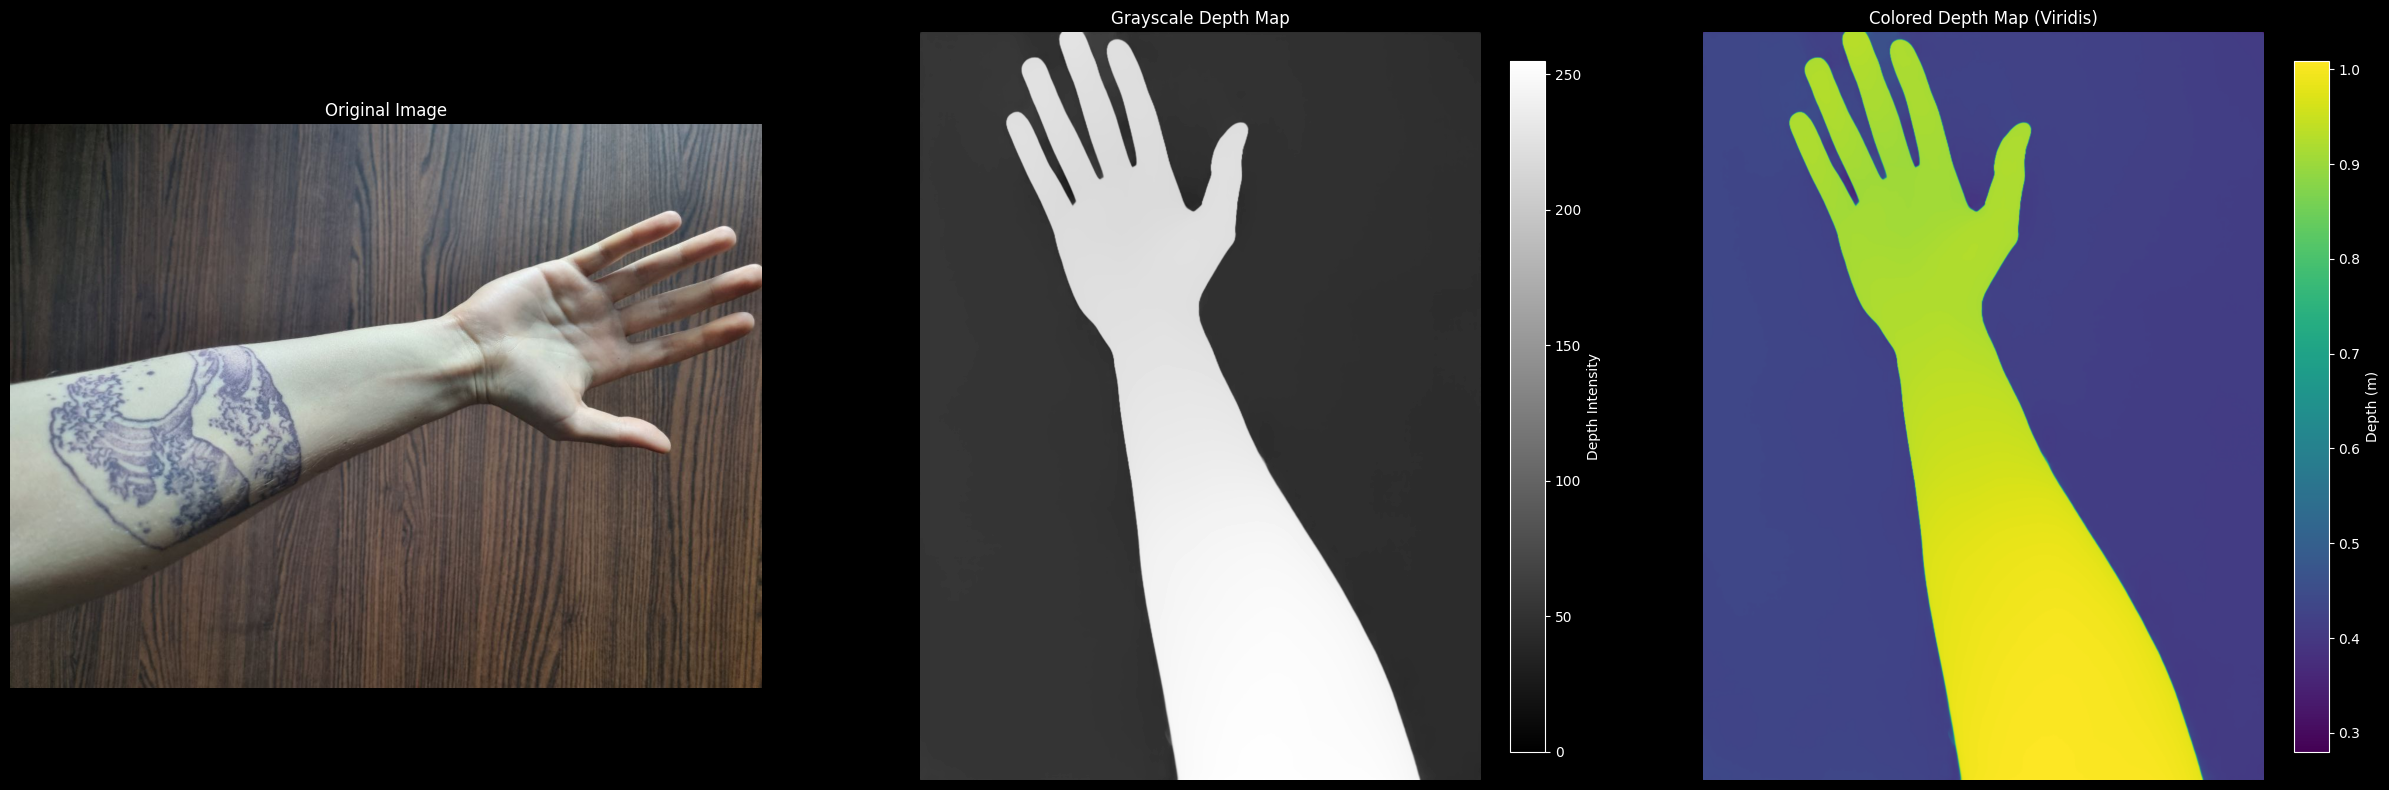

In [ ]:
original_image = Image.open(image_path).convert('RGB').rotate(-90, expand=True)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

im1 = axs[1].imshow(depth_scaled, cmap='gray')
axs[1].set_title('Grayscale Depth Map')
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Depth Intensity')

im2 = axs[2].imshow(depth_colored)
axs[2].set_title('Colored Depth Map (Viridis)')
axs[2].axis('off')

sm = cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=depth_min, vmax=depth_max))
sm.set_array([])
fig.colorbar(sm, ax=axs[2], fraction=0.046, pad=0.04, label='Depth (m)')

plt.tight_layout()
plt.show()

